# Simple PID Controller Implementation in Python

Most codes from http://asl.stanford.edu/aa274/

In [1]:
import numpy as np
import math
from numpy import linalg
from scipy.integrate import cumtrapz
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from utils import *

# Constants
tf = 15
V_max = 0.5
om_max = 1

# time
dt = 0.005
N = int(tf/dt)
t = dt*np.array(range(N+1)) 

# Initial conditions
x_0 = 0
y_0 = 0
V_0 = V_max
th_0 = -np.pi/2
xd_0 = V_0*np.cos(th_0)
yd_0 = V_0*np.sin(th_0)

# Final conditions
x_f = 5
y_f = 5
V_f = V_max
th_f = -np.pi/2
xd_f = V_f*np.cos(th_f)
yd_f = V_f*np.sin(th_f)

In [2]:
def differential_flatness_trajectory():
    '''
    This function solves a system of equations and computes the state trajectory.
    and control history (V (t), om(t)). 
    Outputs:
        traj: a numpy array of size [T, state_dim] where T is the number of time steps, and state_dim is 6. 
        The state ordering needs to be [x,y,th,xd,yd,xdd,ydd]
    
    HINT: You may find the function linalg.solve useful
    '''
    ########## Code starts here ##########
    # Linear equations
    A = np.array([[1, 0, 0, 0, 0, 0, 0, 0],  #x_0
                 [1, tf, pow(tf,2), pow(tf,3), 0, 0, 0, 0], #x_f
                 [0, 1, 0, 0, 0, 0, 0, 0], #xd_0
                 [0, 1, 2*tf, 3*pow(tf,2), 0, 0, 0, 0], #xd_f
                 [0, 0, 0, 0, 1, 0, 0, 0], #y_0
                 [0, 0, 0, 0, 1, tf, pow(tf,2), pow(tf,3)], #y_f
                 [0, 0, 0, 0, 0, 1, 0, 0], #yd
                 [0, 0, 0, 0, 0, 1, 2*tf, 3*pow(tf,2)]#yd_f
                 ])
    B = np.array([x_0, x_f, xd_0, xd_f, y_0, y_f, yd_0, yd_f])
    coeff = linalg.solve(A,B)
    traj = np.zeros((N+1,7))
    V = np.zeros((N+1))
    om = np.zeros((N+1))
    # Compute trajectory, store in traj, format: [x,y,th,xd,yd,xdd,ydd]
    for i in range(N+1): #0....N
        traj[i,0] = coeff[0] + coeff[1]*t[i] + coeff[2]*pow(t[i],2) + coeff[3]*pow(t[i],3)
        traj[i,1] = coeff[4] + coeff[5]*t[i] + coeff[6]*pow(t[i],2) + coeff[7]*pow(t[i],3)
        traj[i,3] = coeff[1] + coeff[2]*2*t[i] + coeff[3]*3*pow(t[i],2)
        traj[i,4] = coeff[5] + coeff[6]*2*t[i] + coeff[7]*3*pow(t[i],2)
        traj[i,5] = coeff[2]*2 + coeff[3]*6*t[i]
        traj[i,6] = coeff[6]*2 + coeff[7]*6*t[i]
        traj[i,2] = np.arctan2(traj[i,4], traj[i,3])
        V[i] = linalg.norm(traj[i,3:5])
        om[i] = (traj[i,6]*traj[i,3] - traj[i,5]*traj[i,4])/(V[i]**2)
    ########## Code ends here ##########
    return traj, V, om

In [3]:
def compute_arc_length(V, t):
    '''
    This function computes arc-length s as a function of t.
    Inputs:
        V: a vector of velocities of length T
        t: a vector of time of length T
    Output:
        s: the arc-length as a function of time. s[i] is the arc-length at time t[i]. This has length T.

    HINT: Use the function cumtrapz
    HINT: This should take one line
    '''
    ########## Code starts here ##########
    s = cumtrapz(V, t, initial=0)
    ########## Code ends here ##########
    return s

def rescale_V(V, om):
    '''
    This function computes V_tilde, given the unconstrained solution V, and om.
    Inputs:
        V: vector of velocities of length T. Solution from the unconstrained, differential flatness problem.
        om:  vector of angular velocities of length T. Solution from the unconstrained, differential flatness problem.
    Output:
        V_tilde: Rescaled velocity that satisfies the control constraints.
    HINT: at each timestep V_tilde should be computed as a minimum of the original value V, and values required to ensure _both_ constraints are satisfied

    HINT: This should take one line
    '''
    ########## Code starts here ##########
    V_tilde = np.minimum(np.minimum(abs(V), V_max), om_max*abs(V/om))*np.sign(V)
    ########## Code ends here ##########
    return V_tilde


def compute_tau(V_tilde, s):
    '''
    This function computes the new time history tau as a function of s.
    Inputs:
        V_tilde: a vector of scaled velocities of length T.
        s: a vector of arc-length of length T.
    Output:
        tau: the new time history as a function of time. tau[i] is the time at s[i]. This has length T.

    HINT: Use the function cumtrapz
    HINT: This should take one line
    '''
    ########## Code starts here ##########
    tau = cumtrapz(1/V_tilde, s, initial=0)
    ########## Code ends here ##########
    return tau

def rescale_om(V, om, V_tilde):
    '''
    This function computes the rescaled om control
    Inputs:
        V: vector of velocities of length T. Solution from the unconstrained, differential flatness problem.
        om:  vector of angular velocities of length T. Solution from the unconstrained, differential flatness problem.
        V_tilde: vector of scaled velocities of length T.
    Output:
        om_tilde: vector of scaled angular velocities

    HINT: This should take one line.
    '''
    ########## Code starts here ##########
    om_tilde = om*V_tilde/V
    ########## Code ends here ##########
    return om_tilde

/Users/mottaghi/PycharmProjects/AI4ALL_robatics/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


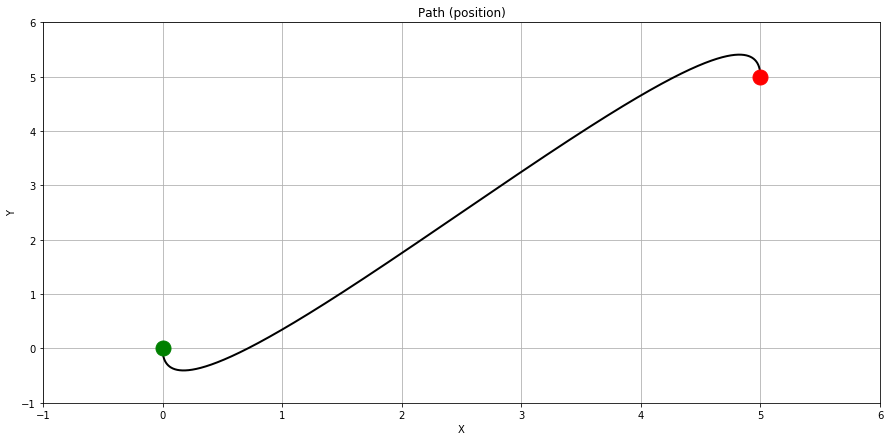

In [4]:
traj, V, om = differential_flatness_trajectory()
s = compute_arc_length(V, t)
V_tilde = rescale_V(V, om)
tau = compute_tau(V_tilde, s)
om_tilde = rescale_om(V, om, V_tilde)

# Get new final time
tf_new = tau[-1]

# Generate new uniform time grid
N_new = int(tf_new/dt)
t_new = dt*np.array(range(N_new+1))
t_new = t_new.T

# Interpolate for state trajectory
data_scaled = np.zeros((N_new+1,7))
data_scaled[:,0] = np.interp(t_new,tau,traj[:,0]) # x
data_scaled[:,1] = np.interp(t_new,tau,traj[:,1]) # y
data_scaled[:,2] = np.interp(t_new,tau,traj[:,2]) # th
# Interpolate for scaled velocities
V_scaled = np.interp(t_new, tau, V_tilde)                # V
om_scaled = np.interp(t_new, tau, om_tilde)              # om
# Compute xy velocities
data_scaled[:,3] = V_scaled*np.cos(data_scaled[:,2]) # xd
data_scaled[:,4] = V_scaled*np.sin(data_scaled[:,2]) # yd
# Compute xy acclerations
data_scaled[:,5] = np.append(np.diff(data_scaled[:,3])/dt,-V_f*om_scaled[-1]*np.sin(th_f)) # xdd
data_scaled[:,6] = np.append(np.diff(data_scaled[:,4])/dt, V_f*om_scaled[-1]*np.cos(th_f)) # ydd

# Save trajectory data
data = {'z': data_scaled, 'V': V_scaled, 'om': om_scaled}
save_dict(data, "data/differential_flatness.pkl")
maybe_makedirs('plots')

# Plots
plt.figure(figsize=(15, 7))
# plt.subplot(2, 2, 1)
plt.plot(data_scaled[:,0], data_scaled[:,1], 'k-',linewidth=2)
plt.grid('on')
plt.plot(x_0, y_0, 'go', markerfacecolor='green', markersize=15)
plt.plot(x_f, y_f, 'ro', markerfacecolor='red', markersize=15)
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Path (position)")
plt.axis([-1, 6, -1, 6])

# plt.subplot(2, 2, 2)
# plt.plot(t, V, linewidth=2)
# plt.plot(t, om, linewidth=2)
# plt.grid('on')
# plt.xlabel('Time [s]')
# plt.legend(['V [m/s]', '$\omega$ [rad/s]'], loc="best")
# plt.title('Original Control Input')
# plt.tight_layout()

# plt.subplot(2, 2, 4)
# plt.plot(t_new, V_scaled, linewidth=2)
# plt.plot(t_new, om_scaled, linewidth=2)
# plt.grid('on')
# plt.xlabel('Time [s]')
# plt.legend(['V [m/s]', '$\omega$ [rad/s]'], loc="best")
# plt.title('Scaled Control Input')
# plt.tight_layout()

# plt.subplot(2, 2, 3)
# plt.plot(t, s, 'b-', linewidth=2)
# plt.grid('on')
# plt.plot(tau, s, 'r-', linewidth=2)
# plt.xlabel('Time [s]')
# plt.ylabel('Arc-length [m]')
# plt.legend(['Original', 'Scaled'], loc="best")
# plt.title('Original and scaled arc-length')
# plt.tight_layout()
plt.savefig("plots/differential_flatness.png")
plt.show()

In [5]:
def ctrl_pose(x, y, th, xg, yg, thg):
    '''
    This function implements the pose stabilization controller.
    Inputs:
        x, y, th: the current pose of the robot
        xg, yg, thg: the desired pose of the robot
    Outputs:
        ctrl: a numpy array np.array([V, om]) containing the desired control inputs

    HINT: you need to use the wrapToPi function
    HINT: don't forget to saturate your control inputs
    '''

    ########## Code starts here ##########

    #Code pose controller
    rel_coords = np.array([x-xg, y-yg])
    R = np.array([[np.cos(thg), np.sin(thg)], [-np.sin(thg), np.cos(thg)]])
    rel_coords_rot = np.dot(R,rel_coords)
    th_rot = th-thg

    # Define the new state variables
    rho = np.linalg.norm(rel_coords)
    ang = np.arctan2(rel_coords_rot[1],rel_coords_rot[0])+np.pi
    angs = wrapToPi(np.array([ang-th_rot, ang]))
    alpha = angs[0]
    delta = angs[1]

    # Gains
    k_1 = 0.4
    k_2 = 0.8
    k_3 = 0.8

    # Final threshold
    eps = 0.001

    if np.abs(rho)>eps or np.abs(alpha)>eps or np.abs(delta)>eps:
        V = k_1*rho*np.cos(alpha)
        om = k_2*alpha + k_1*np.sinc(2*alpha/np.pi)*(alpha+k_3*delta)
    else:
        V = 0.0
        om = 0.0

    #Define control inputs (V,om) - without saturation constraints

    # Apply saturation limits
    V = np.sign(V)*min(0.5, np.abs(V))
    om = np.sign(om)*min(1, np.abs(om))
    ctrl = [V, om]
    ########## Code ends here ##########

    return np.array(ctrl)

(x_0, y_0, th_0) = (5.00, 3.00, 0.00)
t_f = 20.00


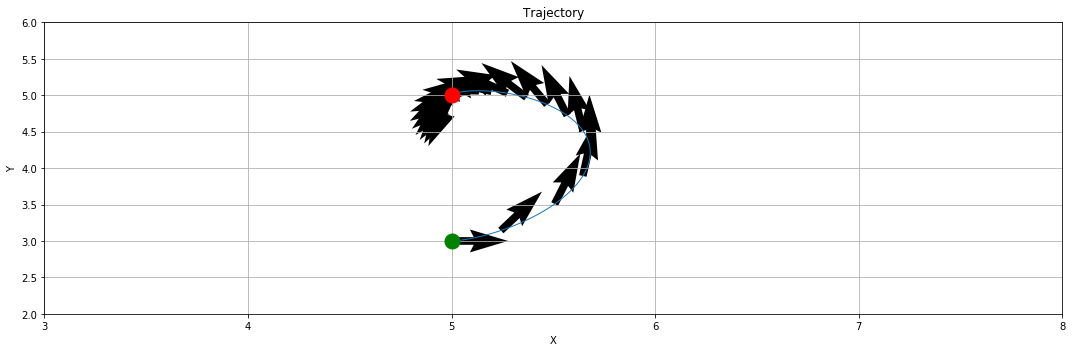

In [6]:
'''
Fill the initial pose (x_0, y_0, th_0), and time duration (t_end) for forward, reverse, and parallel parking.
e.g.

x_0 = 5
y_0 = 3
th_0 = 0
t_end = 20

'''

parking = "parallel"


if parking == "forward":
    ########## Code starts here ##########
    x_0 = 5
    y_0 = 3
    th_0 = 0
    t_end = 20
    ########## Code ends here ##########
elif parking == "reverse":
    ########## Code starts here ##########
    x_0 = 5
    y_0 = 3
    th_0 = 0
    t_end = 20
    ########## Code ends here ##########
elif parking == "parallel":
    ########## Code starts here ##########
    x_0 = 5
    y_0 = 3
    th_0 = 0
    t_end = 20
    ########## Code ends here ##########
else:
    raise ValueError("parking type not known")


print('(x_0, y_0, th_0) = (%.2f, %.2f, %.2f)' %(x_0, y_0, th_0))
print('t_f = %.2f' %t_end)

# desired end pose
x_g = 5
y_g = 5
th_g = -np.pi/2

#timestep
dt = 0.005
N = int (t_end/dt)

# Set up simulation

time = dt * np.array(range(N+1)) 
state = np.zeros((N+1,3))
state[0,:] = np.array([[x_0, y_0, th_0]])
x = state[0,:]

ctrl = np.zeros((N,2))

for i in range(N): 
    ctrl_fbck = ctrl_pose(x[0], x[1], x[2], x_g, y_g, th_g)
    ctrl[i,0] = ctrl_fbck[0]
    ctrl[i,1] = ctrl_fbck[1]

    d_state = odeint(car_dyn, x, np.array([time[i], time[i+1]]), args=(ctrl[i,:], [0,0]) )
    x = d_state[1,:]
    state[i+1,:] = x

# Plots
maybe_makedirs('plots')
plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
plt.plot(state[:,0],state[:,1],linewidth=1)
plt.title('Trajectory')
plt.quiver(state[0:-1:200,0],state[0:-1:200,1],np.cos(state[0:-1:200,2]), np.sin(state[0:-1:200,2]))
plt.grid('on')
plt.plot(x_0,y_0,'go',markerfacecolor='green',markersize=15)
plt.plot(x_g,y_g,'ro',markerfacecolor='red', markersize=15)
plt.xlabel('X')
plt.ylabel('Y')
plt.axis([3,8,2,6])
plt.tight_layout()


# plt.subplot(1,3,2)
# plt.plot(time, state[:,2],linewidth=2)
# plt.grid('on')
# plt.xlabel('Time [s]')
# plt.legend(['$\\theta$ [rad]'],loc='best')
# plt.tight_layout()


# plt.subplot(1,3,3)
# plt.plot(time[0:-1], ctrl, linewidth=2)
# plt.grid('on')
# plt.xlabel('Time [s]')
# plt.legend(['V [m/s]', '$\omega$ [rad/s]'], loc='best')
# plt.title("Control inputs")
# plt.tight_layout()
plt.savefig("plots/" + parking + "_parking.png")
plt.show()


In [7]:
def ctrl_traj(x, y, th,
              ctrl_prev,
              x_d, y_d,
              xd_d, yd_d,
              xdd_d, ydd_d,
              x_g, y_g, th_g):
    '''
    This function computes the closed-loop control law.
    Inputs:
        (x,y,th): current state
        ctrl_prev: previous control input (V,om)
        (x_d, y_d): desired position
        (xd_d, yd_d): desired velocity
        (xdd_d, ydd_d): desired acceleration
        (x_g,y_g,th_g): desired final state
    Outputs:
        (V, om): a numpy array np.array([V, om]) containing the desired control inputs
    '''

    # Timestep
    dt = 0.005
    
    ########## Code starts here ##########
    # Gains
    kpx = 4
    kpy = 4
    kdx = 2
    kdy = 2

    # Define control inputs (V,om) - without saturation constraints
    # Switch to pose controller once "close" enough, i.e., when
    # the robot is within 0.5m of the goal xy position.
    rho = linalg.norm([x_g-x, y_g-y])
    if (rho <= 0.5):
        # Switch to pose-tracking once close enough to final goal
        ctrl = ctrl_pose(x,y,th,x_g,y_g,th_g)
        V = ctrl[0]
        om = ctrl[1]
    else:
        V_prev = ctrl_prev[0]
        if V_prev <= 0.001:
            V_prev = linalg.norm([xd_d, yd_d])
        xd = V_prev*np.cos(th)
        yd = V_prev*np.sin(th)
        u = np.array([xdd_d + kpx*(x_d-x) + kdx*(xd_d-xd),
                      ydd_d + kpy*(y_d-y) + kdy*(yd_d-yd)])
        J = np.array([[np.cos(th), -V_prev*np.sin(th)],
                      [np.sin(th), V_prev*np.cos(th)]])
        a, om = linalg.solve(J, u)
        V = V_prev + a*dt

    # Apply saturation limits
    V = np.sign(V)*min(0.5, np.abs(V))
    om = np.sign(om)*min(1, np.abs(om))
    ########## Code ends here ##########

    return np.array([V, om])

filename: data/differential_flatness.pkl
(x_0, y_0, th_0) = (0.00, 0.00, -1.57)
Noise: 2
Control: closed


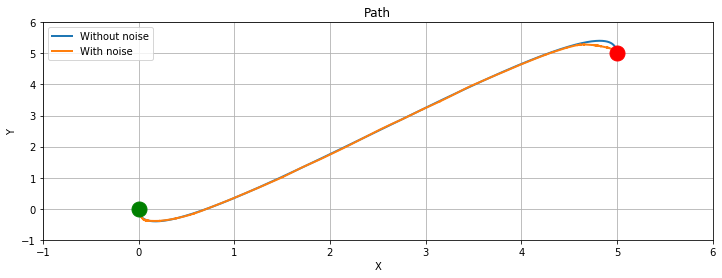

In [8]:
# unpack argv
# script_name, filename, x_0, y_0, th_0, dist, ctrl = argv
x_0 = 0
y_0 = 0
th_0 = -1.57
dist = 2
ctrl = 'closed'
data = 'differential_flatness'
filename = 'data/' + data + '.pkl'

model_name = 'sim_traj_' + data + '_' + str(dist) + '_' + ctrl

print('filename: %s' % filename)
print('(x_0, y_0, th_0) = (%.2f, %.2f, %.2f)' %(x_0, y_0, th_0))
print('Noise: %i' %dist)
print('Control: %s' %ctrl)

data_dict = load_dict(filename)
data = data_dict['z']
V = data_dict['V']
om = data_dict['om']

x_g = data[-1,0]
y_g = data[-1,1]
th_g = data[-1,2]

N = [len(data)-1]
dt = 0.005
t_end = N[0]*dt

noise = np.zeros((N[0]+1,2))
w_noise = 0
n_runs = 1
feedback = False

if dist or ctrl == 'closed': n_runs = 2

if dist: w_noise = dist

if ctrl == 'closed': feedback = True

# Setup Simulation
time = [dt * np.array(range(N[0] + 1))] 
state = [np.zeros((N[0] + 1, 3))]
state[0][0,:] = data[0, 0:3]
ctrl = [np.zeros((N[0], 2))]
if n_runs == 2:
    if feedback: t_end_2 = 1.2 * t_end
    else: t_end_2 = t_end
    N.append(int(t_end_2/dt))
    time.append(dt * np.array(range(N[1] + 1)))

    state.append(np.zeros((N[1] + 1,3)))
    state[1][0,:] = np.array([[x_0, y_0, th_0]])
    ctrl.append(np.zeros((N[1], 2)))

# Simulate
for n in range(n_runs):
    x = state[n][0,:]
    ctrl_prev = np.array([V[0], om[0]])

    if n == 1:
        noise = w_noise*np.vstack([np.sqrt(0.1)*np.random.randn(N[1]), np.sqrt(0.1)*np.random.randn(N[1])])
        noise = noise.T

    for i in range(N[n]): #t[0]...t[N-1]
        idx = N[0] if (n==1) and (i >= N[0]) else i
        # if (n==1) and (i >= N[0]): idx = N[0]
        # else: idx = i

        if n == 0:
            #Open-loop
            ctrl[n][i,:] = np.array([V[i], om[i]])

        elif (n == 1) and (feedback==False):
            #Open-loop
            ctrl[n][i,:] = np.array([V[i], om[i]])
        else:
            #Closed-loop
            ctrl_fbck = ctrl_traj(x[0], x[1], x[2], 
                                 ctrl_prev, 
                                 data[idx,0], data[idx,1], 
                                 data[idx,3], data[idx,4],
                                 data[idx,5], data[idx,6],
                                 x_g, y_g, th_g)
            ctrl[n][i,:] = ctrl_fbck
            ctrl_prev = ctrl[n][i,:]

        d_state = odeint(car_dyn, x, np.array([time[n][i], time[n][i+1]]), args=(ctrl[n][i,:], noise[i,:]))
        x = d_state[1,:]
        state[n][i+1,:] = x

# Plots
maybe_makedirs('plots')
plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)

for n in range(n_runs):
    plt.plot(state[n][:,0],state[n][:,1],linewidth=2)

if (n_runs == 2) and dist:
    plt.legend(['Without noise', 'With noise'], loc="best")
elif (n_runs == 2) and ~dist:
    plt.legend(['Open-loop', 'Closed-loop'], loc="best")

plt.grid('on')
plt.plot(x_0, y_0, 'go', markerfacecolor='green', markersize=15)
plt.plot(x_g, y_g, 'ro', markerfacecolor='red', markersize=15)
plt.xlabel('X')
plt.ylabel('Y')
plt.axis([-1, 6, -1, 6])
plt.title('Path')

# plt.subplot(1,3,2)
# plt.plot(time[0][0:-1], ctrl[0],linewidth=2)
# plt.grid('on')
# plt.xlabel('Time [s]')
# plt.legend(['V [m/s]', '$\omega$ [rad/s]'], loc='best')
# plt.tight_layout()
# if dist: 
#     plt.title('Without noise')
# else: 
#     plt.title('Open-loop')

# if n_runs == 2:
#     plt.subplot(1, 3 ,3)
#     plt.plot(time[1][0:-1], ctrl[1], linewidth=2)
#     plt.grid('on')
#     plt.xlabel('Time [s]')
#     plt.legend(['V [m/s]', '$\omega$ [rad/s]'], loc='best')
#     plt.tight_layout()
#     if dist: plt.title('With noise')
#     else: plt.title('Closed-loop')
plt.savefig('plots/' + model_name + '.png')
plt.show()